In [36]:
# -------------------------------------------
# Notebook 1 Data Pipeline and Model Training (Azure-Inspired)
# -------------------------------------------

In [37]:
import pandas as pd
import numpy as np
import os
import json
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [38]:
# ------------------------------
# Setup folders (simulate Azure ML structure)
# ------------------------------
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("metrics", exist_ok=True)

# ------------------------------
# Load UCI Adult Dataset from working URL
# ------------------------------
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

data_path = "data/adult.csv"
df = pd.read_csv(url, names=columns, sep=',', skipinitialspace=True)
df.to_csv(data_path, index=False)  # Save locally

# ------------------------------
# Preprocessing
# ------------------------------
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# Encode target variable
df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols)

# ------------------------------
# Train/Test Split
# ------------------------------
X = df.drop("income", axis=1)
y = df["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# Pipeline + Hyperparameter Tuning
# ------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__n_estimators': [50, 100]},
             scoring='accuracy')

Best Parameters: {'clf__max_depth': 20, 'clf__n_estimators': 100}
Test Accuracy: 0.8613


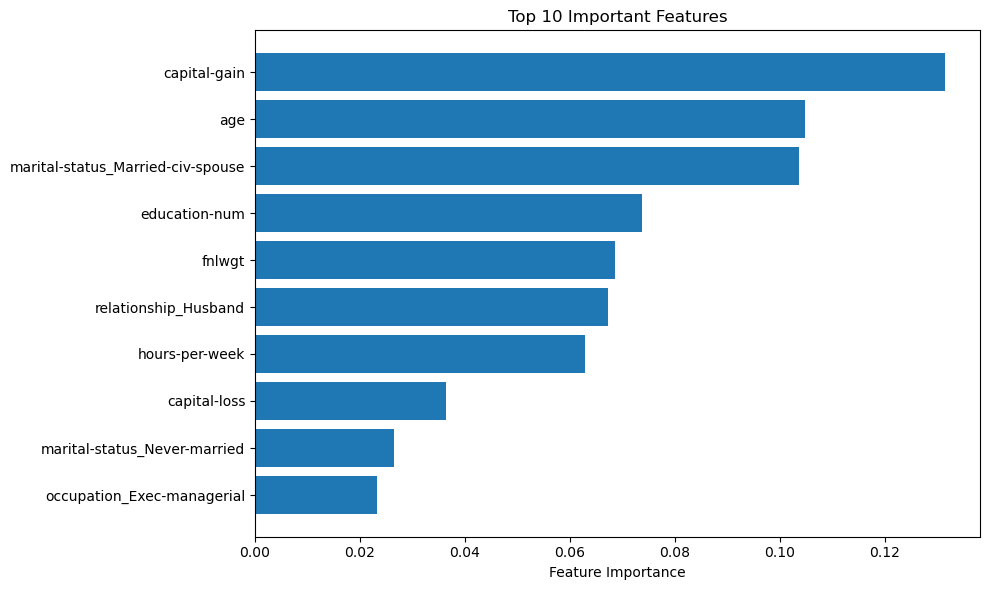

In [39]:
# ------------------------------
# Evaluation
# ------------------------------
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print(f"Best Parameters: {grid.best_params_}")
print(f"Test Accuracy: {acc:.4f}")

# ------------------------------
# Save Model & Metrics
# ------------------------------
joblib.dump(grid.best_estimator_, "models/random_forest_model.pkl")

with open("metrics/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "best_params": grid.best_params_,
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],
        "f1-score": report['1']['f1-score']
    }, f, indent=4)

# ------------------------------
# Visualize Feature Importance
# ------------------------------
model = grid.best_estimator_.named_steps['clf']
importances = model.feature_importances_

feat_names = X.columns
sorted_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), [feat_names[i] for i in sorted_idx][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.savefig("metrics/feature_importance.png")
plt.show()